Adding batch normalization (everywhere, just like in the original source code).

# Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
#!pip install einops
#from einops import rearrange

import torch.optim
import torch.utils.data
# !pip install torchvision==0.11.1
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import matplotlib.pyplot as plt

# Datasets

### CIFAR10

In [ ]:
#from timm.models.layers import DropPath

In [3]:
PATH="datasets"

In [ ]:
cuda = True
batch_size = 64
train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
    ]))

train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets


### Oxford IIIT Pet (segmentation)

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [5]:
def load_image(datapoint):
    # print(type(datapoint["image"]))
    # input_image = tfds.as_numpy(datapoint["image"])
    input_image = tf.cast(datapoint["image"], tf.float32) / 255.0
    input_mask = datapoint["segmentation_mask"]

    return input_image, input_mask

train_dataset = dataset['train'].map(load_image)
test_dataset = dataset['test'].map(load_image)

In [6]:
transform_i = transforms.Compose([
        transforms.Resize((256,256)),
        # transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
    ])

transform_o = transforms.Compose([
        transforms.Resize((256,256))
    ])

def from_tf_to_torch(data):
    torchX, torchy = [], []
    for i,(X,y) in enumerate(data):
        torchX.append(transform_i(torch.permute(torch.Tensor(X.numpy()),(2,0,1))))
        torchy.append(transform_o(torch.permute(torch.Tensor(y.numpy()),(2,0,1))))
    return torch.stack(torchX), torch.stack(torchy)

In [7]:
imgs,labels = from_tf_to_torch(train_dataset)

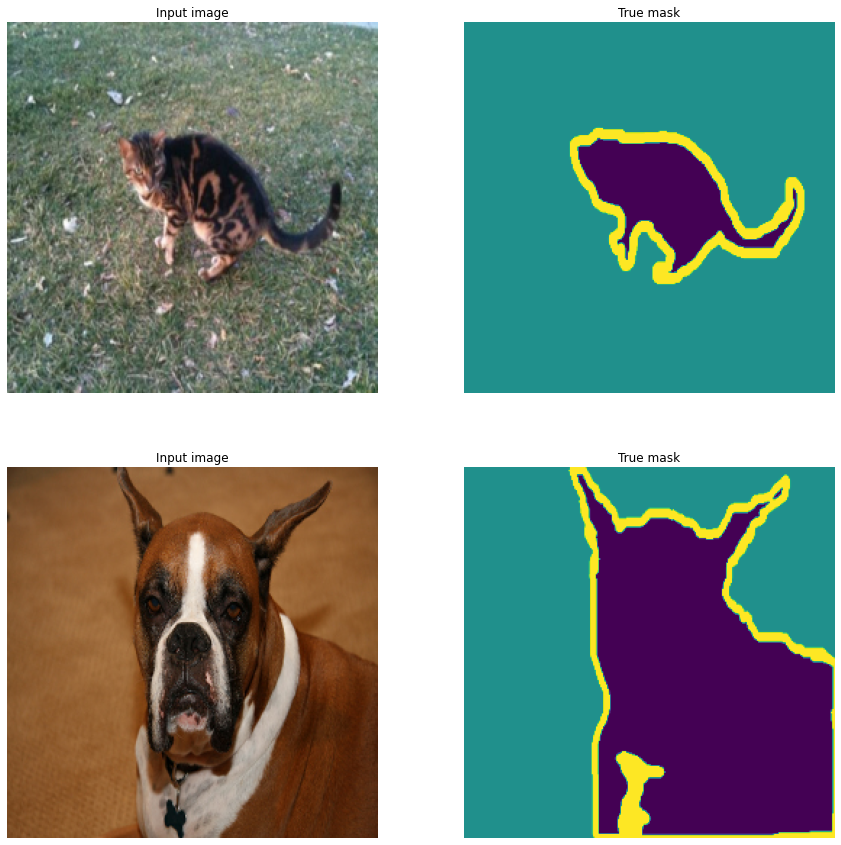

In [24]:
def display(imgs,labels,prediction=None,n=2):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    idx = np.random.choice(np.arange(imgs.shape[0]),n)

    for i,id in enumerate(idx):
        if prediction is None:
            plt.subplot(n,2,i*2+1)
            plt.title("Input image")
            plt.imshow(torch.permute(imgs[id],(1,2,0)))
            plt.axis('off')

            plt.subplot(n,2,i*2+2)
            plt.title("True mask")
            plt.imshow(torch.permute(labels[id],(1,2,0)).reshape((256,256)))
            plt.axis('off')
        else:
            plt.subplot(n,3,i*3+1)
            plt.title("Input image")
            plt.imshow(torch.permute(imgs[id],(1,2,0)))
            plt.axis('off')

            plt.subplot(n,3,i*3+2)
            plt.title("True mask")
            plt.imshow(torch.permute(labels[id],(1,2,0)).reshape((256,256)))
            plt.axis('off')

            plt.subplot(n,3,i*3+3)
            plt.title("Predicted mask")
            plt.imshow(torch.permute(prediction[id],(1,2,0)).reshape((256,256)))
            plt.axis('off')
    plt.show()

display(imgs,labels)

# Model

In [ ]:
def imgs_to_SoP(imgs):
    shape = imgs.shape
    height = shape[-2]
    width = shape[-1]
    batch = shape[0]
    
    ind_w = torch.arange(width)/(width-1)-0.5
    ind_h = torch.arange(height)/(height-1)-0.5
    ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)
    
    batch_ind = ind.repeat(batch,1,1,1)
    #flat_imgs = imgs.flatten(start_dim=len(shape)-2) #laisser en b c h w ?
    
    SoP = torch.cat((imgs,batch_ind),dim=1)
    
    return SoP

In [ ]:
height = 64
width = 32
ind_w = torch.arange(width)/(width-1)-0.5
ind_h = torch.arange(height)/(height-1)-0.5
ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)
ind.repeat(20,1,1,1).shape


torch.Size([20, 2, 64, 32])

In [ ]:
#X,y = next(iter(train_loader))
X = torch.randn(32,3,224,122)
print(X.shape)
print(imgs_to_SoP(X).shape)

torch.Size([32, 3, 224, 122])
torch.Size([32, 5, 224, 122])


In [ ]:
class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)

In [ ]:
class PointReducer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=2, stride=2, norm_layer=None):
        super().__init__()
        self.conv2d = nn.Conv2d(in_chan, out_chan, kernel_size, stride)
        self.norm = norm_layer(out_chan) if norm_layer else nn.Identity()

    def forward(self,input):
        out = self.conv2d(input)
        out = self.norm(out)
        return out

In [ ]:
def pairwise_cosine_sim(x1, x2):
    x1_norm = F.normalize(x1, dim=-1) 
    x2_norm = F.normalize(x2, dim=-1)
    
    sim = x1_norm @ x2_norm.transpose(-2,-1) #to compute for each pair in the batch
    
    return sim

In [ ]:
class Cluster(nn.Module):
    def __init__(self,in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2):
        super().__init__()
        
        self.heads = heads
        self.head_dim = head_dim
        self.fold_w = fold_w
        self.fold_h = fold_h
        
        self.fc1 = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
            #heads*head_dim -> we place the heads in the batch later
        self.fcv = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
        self.fc2 = nn.Conv2d(heads*head_dim,out_channels,kernel_size = 1)
        self.center_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        
        self.alpha = nn.Parameter(torch.ones(1)) #initialisation bizarre
        self.beta = nn.Parameter(torch.zeros(1)) #initialisation bizarre
        
    def forward(self,x):
        """
        x : [b,c,h,w]
        """
        _,_,h,w = x.shape 
        
        val = self.fcv(x)
        x = self.fc1(x)

        # separating heads
        x = rearrange(x, "b (e c) h w -> (b e) c h w", e=self.heads)
        val = rearrange(val, "b (e c) h w -> (b e) c h w", e=self.heads) 
        
        #splitting patches 
        if self.fold_w>1 and self.fold_h>1:
            assert w%self.fold_w==0 and h%self.fold_h==0
            x = rearrange(x, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
            val = rearrange(val, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
        _,_,h,w = x.shape
        #computing cluster centers
        cluster_centers = self.center_proposal(x) #(b,c,Cw,Ch)
        center_values = rearrange(self.center_proposal(val) , 'b c h w -> b (h w) c') #(b,Cw*Ch,c) = (b,m,c)
        
        b,c,_,_ = cluster_centers.shape

        #computing similarity
        sim = torch.sigmoid(self.beta + self.alpha*pairwise_cosine_sim(cluster_centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #(b,Cw*Ch,h*w) = (b,m,n)
        sim_max, sim_argmax = sim.max(dim = 1, keepdim = True)
        
        #assigning a cluster to each point
        mask = torch.zeros_like(sim) #(b,m,n)
        mask.scatter_(1, sim_argmax, 1.)
        sim= sim*mask
        
        #computing aggregated feature
        val = rearrange(val, 'b c h w -> b (h w) c')
        out = ((val.unsqueeze(dim=1)*sim.unsqueeze(dim=-1)).sum(dim=2) + center_values)/(mask.sum(dim=-1,keepdim=True)+ 1)
        
        out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        
        #recovering splitted patches
        if self.fold_w>1 and self.fold_h>1:
            out = rearrange(out, "(b f1 f2) c h w -> b c (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
        
        #regrouping heads
        out = rearrange(out, "(b e) c h w -> b (e c) h w", e=self.heads)
        out = self.fc2(out)

        return out

In [ ]:
class MLP(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,act,dropout=0):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels,hidden_channels,kernel_size=1),act(),\
                  nn.Conv2d(hidden_channels,out_channels,kernel_size=1),act()]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        out = self.net(x)
        return out

In [ ]:
#add droppath ???
class ClusterBlock(nn.Module):
    
    def __init__(self,in_channels,act=nn.GELU,mlp_ratio=4,dropout=0,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2,heads=4,head_dim=16,norm_layer=GroupNorm):
        super().__init__()
        
        #(in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2))
        self.cluster = Cluster(in_channels,in_channels,heads,head_dim,proposal_w,proposal_h,fold_w,fold_h)
        hidden_dim = int(mlp_ratio*in_channels)
        self.mlp = MLP(in_channels,hidden_dim,in_channels,act,dropout=dropout)
        self.norm1 = norm_layer(in_channels)
        self.norm2 = norm_layer(in_channels)
        
    def forward(self,x):
        x = x + self.cluster(self.norm1(x)) #skip conn
        out = x + self.mlp(self.norm2(x)) #skip conn
        return out

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,norm_layer=GroupNorm):
        super().__init__()
        self.point_red = PointReducer(in_channels,out_channels)
        self.cluster_b = ClusterBlock(out_channels,norm_layer=norm_layer)
    
    def forward(self,x):
        x = self.point_red(x)
        x = self.cluster_b(x)
        return x

In [ ]:
class Model(nn.Module):
    def __init__(self,embedding_sizes,num_classes,norm_layer=GroupNorm):
        super().__init__()
        layers = []
        in_channels = 5
        for out_channels in embedding_sizes:
            layers.append(BasicBlock(in_channels,out_channels,norm_layer=norm_layer))
            in_channels = out_channels

        self.feature_extractor = nn.Sequential(*layers)
        self.clf = nn.Linear(embedding_sizes[-1],num_classes)
        self.old_shape = None


    def imgs_to_SoP(self,imgs):
        """
        Transform a batch of images to a bacth of sets of points

        imgs : torch.Tensor([batch,chan,height,width])
        return : torch.Tensor([batch,chan+2,height*width])
        """
        shape = imgs.shape
        if self.old_shape != shape:
            self.old_shape = shape
            height = shape[-2]
            width = shape[-1]
            batch = shape[0]
            
            ind_w = torch.arange(width)/(width-1)-0.5
            ind_h = torch.arange(height)/(height-1)-0.5
            ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)

            self.batch_ind = ind.repeat(batch,1,1,1)
        
        device = imgs.device
        #flat_imgs = imgs.flatten(start_dim=len(shape)-2)
        SoP = torch.cat((imgs,self.batch_ind.to(device)),dim=1) #might need to clone
        
        return SoP

    def forward(self,input):
        SoP = self.imgs_to_SoP(input)
        features = self.feature_extractor(SoP)
        features = torch.mean(features, dim = (2,3))
        yhat = self.clf(features)
        return yhat

# Tests

In [ ]:
def main_10(model,n_epochs,device):
    cuda = True

    batch_size = 64
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    
    test_dataset = datasets.CIFAR10(PATH, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    

    Loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters())
    
    List_Loss = []

    for epoch in range(n_epochs):
        losses = []
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optim.zero_grad()
            
            yhat = model(X)

            l = Loss(yhat,y)
            l.backward()
            
            optim.step()
            losses.append(l.detach().cpu())
        
        acc = 0
        total = 0
        for X,y in test_loader:
            X,y = X.to(device), y.to(device)
            yhat = model(X)

            y_pred = torch.argmax(yhat,dim = 1)
            acc += torch.sum(y==y_pred)
            total += len(y)
            l = Loss(yhat,y)
            
        List_Loss.append(torch.mean(torch.stack(losses)).detach().cpu())
        print(f"epoch n°{epoch} : loss = {List_Loss[-1]}, acc = {acc.item()/total}")
    
    
    plt.plot(range(n_epochs),List_Loss)


In [ ]:
def main_100(model,n_epochs,device):
    cuda = True

    batch_size = 64
    train_dataset = datasets.CIFAR100(PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    
    test_dataset = datasets.CIFAR100(PATH, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    

    Loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters())
    
    List_Loss = []

    for epoch in range(n_epochs):
        losses = []
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optim.zero_grad()
            
            yhat = model(X)

            l = Loss(yhat,y)
            l.backward()
            optim.step()
            losses.append(l.detach().cpu())
        
        acc = 0
        total = 0
        for X,y in test_loader:
            X,y = X.to(device), y.to(device)
            yhat = model(X)

            y_pred = torch.argmax(yhat,dim = 1)
            acc += torch.sum(y==y_pred)
            total += len(y)
            l = Loss(yhat,y)
            
        List_Loss.append(torch.mean(torch.stack(losses)).detach().cpu())
        print(f"epoch n°{epoch} : loss = {List_Loss[-1]}, acc = {acc.item()/total}")
    
    
    plt.plot(range(n_epochs),List_Loss)


Files already downloaded and verified
Files already downloaded and verified
epoch n°0 : loss = 1.6393811702728271, acc = 0.4978
epoch n°1 : loss = 1.3059080839157104, acc = 0.5345
epoch n°2 : loss = 1.1236858367919922, acc = 0.5975
epoch n°3 : loss = 1.0066052675247192, acc = 0.6276
epoch n°4 : loss = 0.9198486804962158, acc = 0.637
epoch n°5 : loss = 0.843468189239502, acc = 0.6532
epoch n°6 : loss = 0.779719889163971, acc = 0.6545
epoch n°7 : loss = 0.7252682447433472, acc = 0.6632
epoch n°8 : loss = 0.6718530654907227, acc = 0.6681
epoch n°9 : loss = 0.613284707069397, acc = 0.6658
epoch n°10 : loss = 0.5647108554840088, acc = 0.6665
epoch n°11 : loss = 0.5182480812072754, acc = 0.6669
epoch n°12 : loss = 0.46663251519203186, acc = 0.671
epoch n°13 : loss = 0.4281984865665436, acc = 0.6754
epoch n°14 : loss = 0.3899250030517578, acc = 0.6659
epoch n°15 : loss = 0.34829476475715637, acc = 0.6763
epoch n°16 : loss = 0.31612369418144226, acc = 0.6641
epoch n°17 : loss = 0.2903408408164

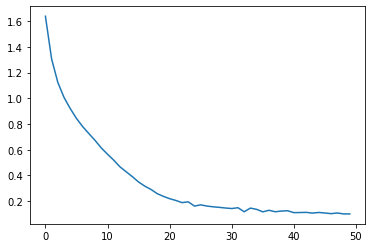

In [ ]:
# With all the normalizations
embedding_sizes = [16,32,64,128]
num_classes = 10
device = 'cuda' #if torch.cuda.is_available() else 'cpu'
model_cifar10 = Model(embedding_sizes,num_classes).to(device)
main_10(model_cifar10,50,device)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting datasets/cifar-100-python.tar.gz to datasets
Files already downloaded and verified
epoch n°0 : loss = 3.8394672870635986, acc = 0.1723
epoch n°1 : loss = 3.258563756942749, acc = 0.2442
epoch n°2 : loss = 2.9296603202819824, acc = 0.2782
epoch n°3 : loss = 2.7040441036224365, acc = 0.3116
epoch n°4 : loss = 2.5174896717071533, acc = 0.3365
epoch n°5 : loss = 2.34407377243042, acc = 0.3399
epoch n°6 : loss = 2.196153163909912, acc = 0.3508
epoch n°7 : loss = 2.05900239944458, acc = 0.3625
epoch n°8 : loss = 1.9395297765731812, acc = 0.3645
epoch n°9 : loss = 1.819610357284546, acc = 0.3675
epoch n°10 : loss = 1.710659146308899, acc = 0.3761
epoch n°11 : loss = 1.5995396375656128, acc = 0.3758
epoch n°12 : loss = 1.4894349575042725, acc = 0.3696
epoch n°13 : loss = 1.3941490650177002, acc = 0.3655
epoch n°14 : loss = 1.299105167388916, acc = 0.3658
epoch n°15 : loss = 1.2025978565216064, acc = 0.3699
epoch n°16 : loss = 1.108523964881897, acc = 0.3577
epoch n°17 : loss = 1.038

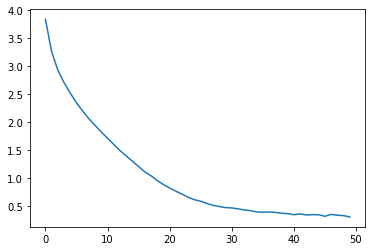

In [ ]:

embedding_sizes = [16,32,64,128]
num_classes = 100
device = 'cuda' #if torch.cuda.is_available() else 'cpu'
model_cifar100 = Model(embedding_sizes,num_classes).to(device)
main_100(model_cifar100,50,device)

In [ ]:
pr1 = PointReducer(5,16)
cb1 = ClusterBlock(16)

pr2 = PointReducer(16,32)
cb2 = ClusterBlock(32)

pr3 = PointReducer(32,64)
cb3 = ClusterBlock(64)

pr4 = PointReducer(64,128)
cb4 = ClusterBlock(128)

clf = nn.Linear(128,10)

In [ ]:
X = torch.randn(32,3,64,128)
X = imgs_to_SoP(X)
X.shape

torch.Size([32, 5, 64, 128])

In [ ]:
X = pr1(X)
print(X.shape)
X = cb1(X)
print(X.shape)

torch.Size([32, 16, 32, 64])
torch.Size([32, 16, 32, 64])


In [ ]:
X = pr2(X)
print(X.shape)
X = cb2(X)
print(X.shape)

torch.Size([32, 32, 16, 32])
torch.Size([32, 32, 16, 32])


In [ ]:
X = pr3(X)
print(X.shape)
X = cb3(X)
print(X.shape)

torch.Size([32, 64, 8, 16])
torch.Size([32, 64, 8, 16])


In [ ]:
X = pr4(X)
print(X.shape)
X = cb4(X)
print(X.shape)

torch.Size([32, 128, 4, 8])
torch.Size([32, 128, 4, 8])


In [ ]:
X = torch.mean(X, dim = (2,3))
X.shape

torch.Size([32, 128])

In [ ]:
y = clf(X)
y.shape

torch.Size([32, 10])

# Tests Basic Blocks

In [ ]:
b1 = BasicBlock(5,16)
b2 = BasicBlock(16,32)
b3 = BasicBlock(32,64)
b4 = BasicBlock(64,128)
clf = nn.Linear(128,10)

In [ ]:
X = torch.randn(32,3,64,128)
X = imgs_to_SoP(X)

X = b1(X)
X = b2(X)
X = b3(X)
X = b4(X)

X = torch.mean(X, dim = (2,3))

y = clf(X)
print(y.shape)

torch.Size([32, 10])
